In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data

class AutoEncoder(nn.Module):
    def __init__(self):
        '''
            Model initialize
        '''
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, return_indices = True)

        # Decoder
        self.unpool = nn.MaxUnpool2d(2)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3)
        self.deconv1 = nn.ConvTranspose2d(32, 3, 3)

        # Save for Unpooling
        self.indices = []

        return
    
        
    def forward(self, input):
        # Encoder
        x = torch.relu(self.conv1(input))
        x, ind1 = self.pool(x)
        x = torch.relu(self.conv2(x))
        x, ind2 = self.pool(x)
        self.indices = [ind1, ind2]

        # latent vector
        latent = x

        # Decode
        x = self.unpool(x, self.indices[1])
        x = torch.relu(self.deconv2(x))
        x = self.unpool(x, self.indices[0])
        output = torch.relu(self.deconv1(x))

        return output, latent

    def addnoise(self, latent):
        # addnoise to latent
        x = latent + torch.normal(mean = 0, std = 0.3, size = latent.size())

        # Decode to origin
        x = self.unpool(x, self.indices[1])
        x = torch.relu(self.deconv2(x))
        x = self.unpool(x, self.indices[0])
        output = torch.relu(self.deconv1(x))

        return output


        


In [24]:


class DataAugmentation(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, transform = None):
        'Initialization'
        self.list_IDs = list_IDs
        self.labels = labels
        self.transform = transform

        return

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        if self.transform: 
            ID = self.transform(ID)

        return ID, label[index]

In [25]:
def Training(device, train_loader, epochs, draw = True):

    # Hyperparameter
    AE = AutoEncoder().double().to(device)
    evaluate = nn.MSELoss()
    optimizer = optim.AdamW(AE.parameters(), lr=0.001)

    plot_x = [i for i in range(epochs)]
    plot_training_loss = []

    # Training
    for epoch in range(epochs):
        total_loss = 0.

        for batch_x, batch_y in train_loader:
            # convert to gpu or cpu
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad() 

            # forward
            outputs, latent = AE.forward(batch_x)

            # backward
            loss = evaluate(outputs, batch_x)

            # backward pass: compute gradient of the loss with respect to model parameters#
            loss.backward()

            # parameter update
            optimizer.step() 

            # update running training loss
            total_loss += loss
            
        # print avg training statistics 
        total_loss /= len(train_loader.dataset)
        print('Epoch {}, Training Loss: {:.6f}'.format(epoch + 1, total_loss.item()))
        plot_training_loss.append(total_loss.item())
    
    if draw:
        plt.plot(plot_x, plot_training_loss, lw = 2, label = 'train_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training loss')
        plt.savefig('./Training')
        plt.show()
        plt.close()

    return AE

Epoch 1, Training Loss: 0.014662
Epoch 2, Training Loss: 0.004281
Epoch 3, Training Loss: 0.003219
Epoch 4, Training Loss: 0.002605
Epoch 5, Training Loss: 0.002275
Epoch 6, Training Loss: 0.002060
Epoch 7, Training Loss: 0.001894
Epoch 8, Training Loss: 0.001791
Epoch 9, Training Loss: 0.001682
Epoch 10, Training Loss: 0.001627
Epoch 11, Training Loss: 0.001540
Epoch 12, Training Loss: 0.001471
Epoch 13, Training Loss: 0.001406
Epoch 14, Training Loss: 0.001362
Epoch 15, Training Loss: 0.001320
Epoch 16, Training Loss: 0.001292
Epoch 17, Training Loss: 0.001271
Epoch 18, Training Loss: 0.001223
Epoch 19, Training Loss: 0.001179
Epoch 20, Training Loss: 0.001163


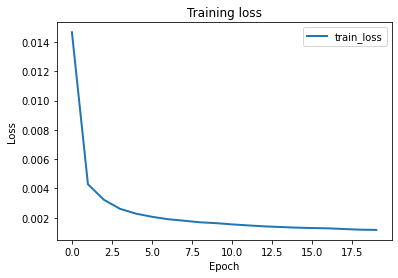

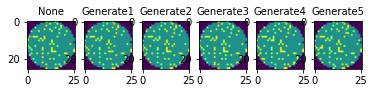

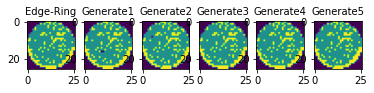

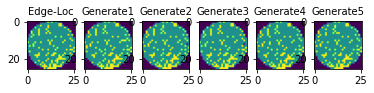

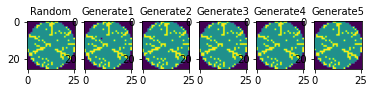

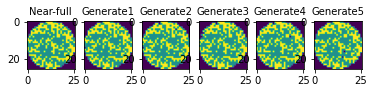

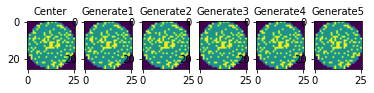

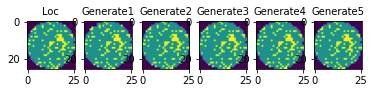

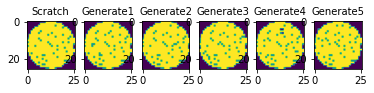

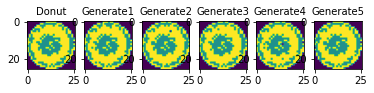

In [26]:
   
device = torch.device("cpu")

# numpy array data
data = np.load('/content/drive/MyDrive/hw2_106091228/Data/data.npy')
label = np.load('/content/drive/MyDrive/hw2_106091228/Data/label.npy')

# data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    ])

# Data Loader
train_loader = Data.DataLoader(dataset = DataAugmentation(data, label, transform), batch_size=4)

# Training 
AE = Training(device, train_loader, epochs = 20)

# Evaluation
AE.eval()

# Generate 1281*5 image
input = torch.from_numpy(data.transpose(0, 3, 2, 1)).to(device)

label_name = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'None']
    # 9 class first index position 
label_index = {414, 997, 405, 404, 415, 413, 412, 425, 0}

data_generator = []
label_generator = []

for i, data in enumerate(input):
    # add axis to 4-dim
    data = data.unsqueeze(0)

    # Remove axis
    org, latent = AE.forward(data)
    org = torch.squeeze(org, 0)

    # Add noise, Decode, Remove axis to 3-dim
    gen = []
    for _ in range(5):
        # reconstruct noise output
        tmp = AE.addnoise(latent)
        tmp = torch.squeeze(tmp, 0)
        gen.append(tmp)
        data_generator.append(tmp.cpu().detach().numpy().transpose(2, 1, 0))
        label_generator.append(label[i])

    # generate image
    if i in label_index:
    # Convert to numpy
        org_np = org.cpu().detach().numpy().transpose(2, 1, 0)
        gen_np = [gen[k].cpu().detach().numpy().transpose(2, 1, 0) for k in range(5)]
        label_index.remove(i)
        fig, ax = plt.subplots(1, 6)
        ax[0].imshow(np.argmax(org_np, 2))
        ax[0].set_title(label_name[label[i][0]], fontsize=10)
        for k in range(1, 6):
            ax[k].imshow(np.argmax(gen_np[k-1], 2))
            ax[k].set_title('Generate'+str(k), fontsize=10)
        fig.savefig('./'+label_name[label[i][0]])
    
# Save generation data and label
data_generator = np.array(data_generator)
label_generator = np.array(label_generator)

np.save('/content/drive/MyDrive/hw2_106091228/Data/data_generator.npy', data_generator)
np.save('/content/drive/MyDrive/hw2_106091228/Data/label_generator.npy', label_generator)



In [27]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = AutoEncoder().to(device)

summary(model, (3, 26, 26))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             896
         MaxPool2d-2  [[-1, 32, 12, 12], [-1, 32, 12, 12]]               0
            Conv2d-3           [-1, 64, 10, 10]          18,496
         MaxPool2d-4  [[-1, 64, 5, 5], [-1, 64, 5, 5]]               0
       MaxUnpool2d-5           [-1, 64, 10, 10]               0
   ConvTranspose2d-6           [-1, 32, 12, 12]          18,464
       MaxUnpool2d-7           [-1, 32, 24, 24]               0
   ConvTranspose2d-8            [-1, 3, 26, 26]             867
Total params: 38,723
Trainable params: 38,723
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 181.10
Params size (MB): 0.15
Estimated Total Size (MB): 181.26
----------------------------------------------------------------
